# Bayesian parameter estimation for an LG-SSM using HMC

We show how to use the [blackjax](https://github.com/blackjax-devs/blackjax) libray to compute the parameter posterior $p(\theta|y(1:T))$
for an LGSSM model. We use the Kalman filter to compute the marginal likelihood, $p(y(1:T) | \theta) = \int_{z(1:T)} p(z(1:T), y(1:T)|\theta)$.



## Setup

In [1]:
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -qq git+https://github.com/probml/dynamax.git
    import dynamax

In [2]:
try:
    import blackjax
except ModuleNotFoundError:
    print('installing blackjax')
    %pip install -qq blackjax
    import blackjax

In [3]:
from jax import random as  jr
from jax import numpy as jnp
from jax import jit, vmap
from itertools import count

from dynamax.linear_gaussian_ssm import LinearGaussianSSM
from dynamax.parameters import log_det_jac_constrain

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [16, 9]

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Generate synthetic training data

In [4]:
# Simulate synthetic data from true model
state_dim = 2
emission_dim = 10
num_timesteps = 100
keys = map(jr.PRNGKey, count())

true_model = LinearGaussianSSM(state_dim, emission_dim)
true_params, _ = true_model.initialize(next(keys))
true_states, emissions = true_model.sample(true_params, next(keys), num_timesteps)

In [5]:
def plot_results(emissions, smoothed_emissions, smoothed_emissions_std):
    # all arrays are (T, E) dimensional, T=ntime, E=emission_dim
    spc = 3
    plt.figure(figsize=(10, 4))
    for i in range(emission_dim):
        plt.plot(emissions[:, i] + spc * i, "--k", label="observed" if i == 0 else None)
        ln = plt.plot(smoothed_emissions[:, i] + spc * i,
                    label="smoothed" if i == 0 else None)[0]
        plt.fill_between(
            jnp.arange(num_timesteps),
            spc * i + smoothed_emissions[:, i] - 2 * jnp.sqrt(smoothed_emissions_std[:, i]),
            spc * i + smoothed_emissions[:, i] + 2 * jnp.sqrt(smoothed_emissions_std[:, i]),
            color=ln.get_color(),
            alpha=0.25,
        )
    plt.xlabel("time")
    plt.xlim(0, num_timesteps - 1)
    plt.ylabel("true and predicted emissions")
    plt.legend()

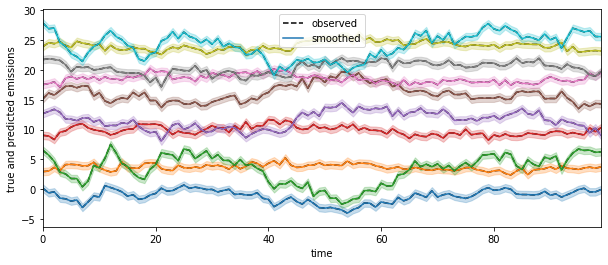

In [6]:
plot_results(emissions, emissions, 0.1*jnp.ones_like(emissions)) # fake posterior variance

## Baseline method: use EM to compute MLE

In [7]:


# Initilize parameters by fitting EM algorithm
num_iters = 100
test_model = LinearGaussianSSM(state_dim, emission_dim)
initial_params, param_props = test_model.initialize(next(keys))
fitted_params, marginal_lls = test_model.fit_em(initial_params, param_props, emissions, num_iters=num_iters)

# Extract fitted params
fitted_C = fitted_params.emissions.weights
fitted_d = fitted_params.emissions.bias
fitted_R = fitted_params.emissions.cov

# Compute predicted emissions
posterior = test_model.smoother(fitted_params, emissions)
smoothed_emissions_mean = posterior.smoothed_means @ fitted_C.T + fitted_d
smoothed_emissions_cov = fitted_C @ posterior.smoothed_covariances @ fitted_C.T + fitted_R
smoothed_emissions_std = jnp.sqrt(
    jnp.array([smoothed_emissions_cov[:, i, i] for i in range(emission_dim)])).T # (T,E)



[(100, 10), (100, 10), (100, 10)]


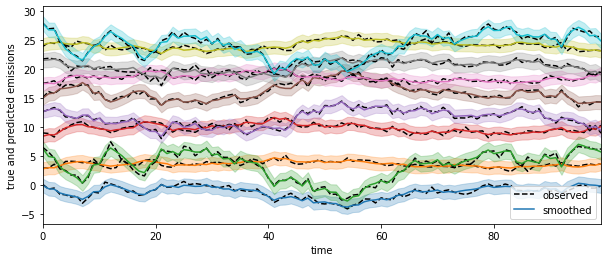

In [8]:
print([emissions.shape, smoothed_emissions_mean.shape, smoothed_emissions_std.shape])
plot_results(emissions, smoothed_emissions_mean, smoothed_emissions_std)


## Implement HMC wrapper

In [9]:
from dynamax.parameters import to_unconstrained, from_unconstrained
from dynamax.utils.utils import pytree_stack, ensure_array_has_batch_dim
from functools import partial
from fastprogress.fastprogress import progress_bar

def fit_hmc(model,
            initial_params,
            props,
            key,
            num_samples,
            emissions,
            inputs=None,
            warmup_steps=100,
            num_integration_steps=30,
            verbose=True):
    """Sample parameters of the model using HMC."""
    # Make sure the emissions and inputs have batch dimensions
    batch_emissions = ensure_array_has_batch_dim(emissions, model.emission_shape)
    batch_inputs = ensure_array_has_batch_dim(inputs, model.inputs_shape)

    initial_unc_params = to_unconstrained(initial_params, props)

    # The log likelihood that the HMC samples from
    def _logprob(unc_params):
        params = from_unconstrained(unc_params, props)
        batch_lls = vmap(partial(model.marginal_log_prob, params))(batch_emissions, batch_inputs)
        lp = model.log_prior(params) + batch_lls.sum()
        lp += log_det_jac_constrain(params, props)
        return lp

    # Initialize the HMC sampler using window_adaptation
    warmup = blackjax.window_adaptation(blackjax.hmc,
                                        _logprob,
                                        num_steps=warmup_steps,
                                        num_integration_steps=num_integration_steps,
                                        progress_bar=verbose)
    init_key, key = jr.split(key)
    hmc_initial_state, hmc_kernel, _ = warmup.run(init_key, initial_unc_params)

    @jit
    def hmc_step(hmc_state, step_key):
        next_hmc_state, _ = hmc_kernel(step_key, hmc_state)
        params = from_unconstrained(hmc_state.position, props)
        return next_hmc_state, params

    # Start sampling
    log_probs = []
    samples = []
    hmc_state = hmc_initial_state
    pbar = progress_bar(range(num_samples)) if verbose else range(num_samples)
    for _ in pbar:
        step_key, key = jr.split(key)
        hmc_state, params = hmc_step(hmc_state, step_key)
        log_probs.append(-hmc_state.potential_energy)
        samples.append(params)

    # Combine the samples into a single pytree
    return pytree_stack(samples), jnp.array(log_probs)


## Call HMC

In [10]:
sample_size = 500
param_samples, lps = fit_hmc(test_model, initial_params, param_props, next(keys), sample_size, emissions, num_integration_steps=30)

Running window adaptation


Text(0.5, 0, 'log probability')

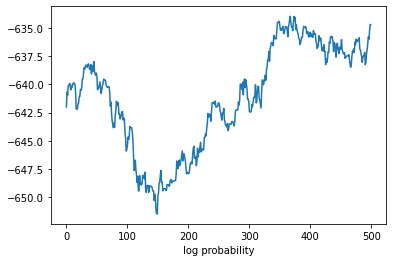

In [18]:
plt.plot(lps)
plt.xlabel("iteration")
plt.xlabel("log probability")

In [19]:
@jit
def smooth_emission(params):
    C = params.emissions.weights
    d = params.emissions.bias
    posterior = test_model.smoother(params, emissions)
    return posterior.smoothed_means @ C.T + d

smoothed_emissions = vmap(smooth_emission)(param_samples)
smoothed_emissions_mean = smoothed_emissions.mean(axis=0)
smoothed_emissions_std = jnp.std(smoothed_emissions, axis=0)

print([emissions.shape, smoothed_emissions.shape, smoothed_emissions_mean.shape, smoothed_emissions_std.shape])

[(100, 10), (500, 100, 10), (100, 10), (100, 10)]


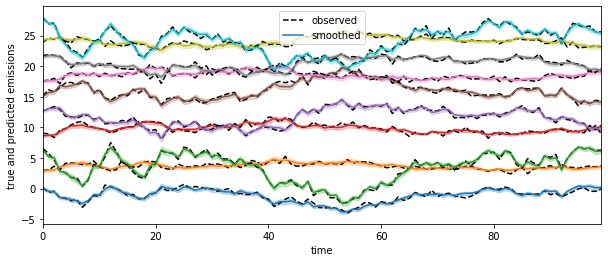

In [20]:
plot_results(emissions, smoothed_emissions_mean, smoothed_emissions_std)

## Use HMC to infer posterior over a subset of the parameters

We freeze the transition parameters and inital parameters, so that only covariance matrices are learned.
This is useful for structural time series models (see e.g., [sts-jax](https://github.com/probml/sts-jax) library, 
which builds on dynamax.).


In [21]:
# Freeze transition parameters and inital parameters, so that only covariance matrices are learned

test_model = LinearGaussianSSM(state_dim, emission_dim)
test_params, test_param_props = test_model.initialize(next(keys),
                                                      dynamics_weights=true_params.dynamics.weights,
                                                      dynamics_bias=true_params.dynamics.bias,
                                                      emission_weights=true_params.emissions.weights,
                                                      emission_bias=true_params.emissions.bias)

# Set transition parameters and inital parameters to true values and mark as frozen
test_param_props.dynamics.weights.trainable = False
test_param_props.dynamics.bias.trainable = False
test_param_props.emissions.weights.trainable = False
test_param_props.emissions.bias.trainable = False

Running window adaptation


Text(0.5, 0, 'log probability')

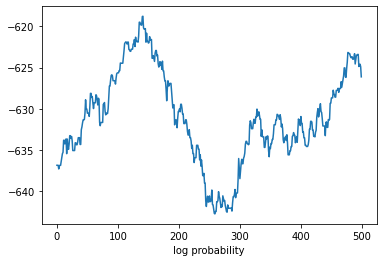

In [22]:
sample_size = 500
param_samples, lps = fit_hmc(test_model, test_params, test_param_props, next(keys), sample_size, emissions, num_integration_steps=30)

plt.plot(lps)
plt.xlabel("iteration")
plt.xlabel("log probability")

In [23]:
@jit
def smooth_emission(params):
    C = params.emissions.weights
    d = params.emissions.bias
    posterior = test_model.smoother(params, emissions)
    return posterior.smoothed_means @ C.T + d

smoothed_emissions = vmap(smooth_emission)(param_samples)
smoothed_emissions_mean = smoothed_emissions.mean(axis=0)
smoothed_emissions_std = jnp.std(smoothed_emissions, axis=0)

print([emissions.shape, smoothed_emissions.shape, smoothed_emissions_mean.shape, smoothed_emissions_std.shape])

[(100, 10), (500, 100, 10), (100, 10), (100, 10)]


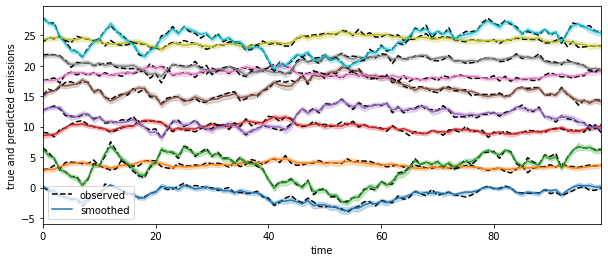

In [24]:
plot_results(emissions, smoothed_emissions_mean, smoothed_emissions_std)